This notebook uses streaming for all data loading. This is crucial because the full SVQ audio dataset is hundreds of gigabytes. Streaming allows you to analyze the metadata and text immediately without downloading the audio files.

# Setup and Installation

This section sets up the environment. It installs the Hugging Face datasets library for data loading, soundfile for robust audio decoding (bypassing the specific errors we saw earlier), and tqdm for progress bars. It also imports all necessary Python libraries globally so they are available for every subsequent section.

In [ ]:
# Environment Setup
# @markdown Run this cell first. It installs necessary dependencies and imports libraries.

# Install dependencies (Quiet mode to reduce log noise)
!pip install datasets pandas tqdm matplotlib soundfile -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from datasets import load_dataset
from tqdm import tqdm
import soundfile as sf
import io
import textwrap

print("✅ Environment ready! You can now run the sections below.")

✅ Environment ready! You can now run the sections below.


# High-Level Dataset Statistics

This section performs a statistical analysis of the audio subset. Because the dataset is massive, it streams the metadata (without downloading audio files) to calculate:

* Examples per Locale: How many queries exist for each language/region (e.g., en_us, ar_eg).

* Environments: The distribution of recording conditions (e.g., clean, car_noise).

* Unique Speakers per Language: A complex metric that groups data by locale and counts how many distinct speaker_ids contributed to each.

In [ ]:
# High-Level Dataset Statistics
# @markdown Scans the dataset metadata to calculate Locales, Environments, and Speaker diversity.

# Load the audio subset in streaming mode
audio_ds = load_dataset("google/svq", "audio", split="test", streaming=True)

data = []
scan_limit = 200000  # @param {type:"integer"}
print(f"📊 Scanning first {scan_limit} rows to generate statistics...")

for i, row in tqdm(enumerate(audio_ds), total=scan_limit):
    if i >= scan_limit:
        break

    # Collect only necessary columns
    data.append({
        'locale': row['locale'],
        'environment': row['environment'],
        'speaker_id': row['speaker_id']
    })

# Convert to Pandas DataFrame for analysis
df = pd.DataFrame(data)

print("\n" + "="*50)
print("DATASET STATISTICS (Sampled)")
print("="*50)

# 1. Examples per Locale
print("\n--- 🌍 Examples per Locale ---")
print(df['locale'].value_counts())

# 2. Environments
print("\n--- 🏙️ Recording Environments ---")
print(df['environment'].value_counts())

# 3. Unique Speakers per Language
print("\n--- 🗣️ Unique Speakers per Locale ---")
speaker_stats = df.groupby('locale')['speaker_id'].nunique().sort_values(ascending=False)
print(speaker_stats)

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

📊 Scanning first 200000 rows to generate statistics...


 86%|████████▌ | 171434/200000 [15:04<02:30, 189.56it/s]



DATASET STATISTICS (Sampled)

--- 🌍 Examples per Locale ---
locale
ar_eg            13811
ar_x_gulf        13452
ar_x_levant      12600
ar_x_maghrebi    12590
ru_ru            11912
te_in            10410
fi_fi            10365
ko_kr             6520
sw                5878
id_id             5726
en_ph             5647
en_us             5633
en_in             5632
en_gb             5586
en_au             5506
bn_in             4726
bn_bd             4119
hi_in             3805
mr_in             3699
gu_in             3689
ur_in             3688
ur_pk             3493
kn_in             3453
ml_in             3353
ta_in             3308
ja_jp             2833
Name: count, dtype: int64

--- 🏙️ Recording Environments ---
environment
clean                43343
traffic_noise        43116
media_noise          43000
background_speech    41975
Name: count, dtype: int64

--- 🗣️ Unique Speakers per Locale ---
locale
ar_eg            59
ar_x_gulf        58
ar_x_maghrebi    57
ar_x_levant      55
f

# Generate "Gold Standard" ID List

This is a critical utility section. The SVQ dataset is hierarchical, meaning not every audio file has a corresponding answer span. This script performs a cross-reference scan:

1. It scans the strictest subset (span_reasoning) to find IDs that
have granular answer spans.

2. It verifies these IDs exist in the clean English audio subset.

3. It prints a list of valid utt_ids that are guaranteed to work in Section 4 (Visualization) and Section 5 (Retrieval).

In [ ]:
# Generate "Gold Standard" ID List (en_us)
# @markdown detailed: Finds `utt_id`s in `en_us` that possess **Audio + Document + Passage + Span** data.

print("🚀 Starting Cross-Reference Scan...")

# 1. Collect IDs from the Strictest Subset (Span Reasoning)
print("\n1️⃣ Scanning 'span_reasoning_in_lang' to find granular answers...")
reasoning_ds = load_dataset("google/svq", "span_reasoning_in_lang", split="test", streaming=True)

valid_ids = set()
scan_limit = 50000 # Scan deep into the dataset

for i, row in tqdm(enumerate(reasoning_ds), total=scan_limit):
    if i >= scan_limit: break

    # Check for English locale
    if row.get('locale') == 'en_us':
        uid = row.get('utt_id') or row.get('id')
        if uid:
            valid_ids.add(uid)

print(f"   -> Found {len(valid_ids)} candidates with reasoning spans.")

# 2. Verify against Audio Subset
print("\n2️⃣ Verifying candidates against 'audio_en_us_clean'...")
audio_ds = load_dataset("google/svq", "audio_en_us_clean", split="test", streaming=True)

final_gold_list = []

for row in tqdm(audio_ds):
    if row['utt_id'] in valid_ids:
        final_gold_list.append(row['utt_id'])

# 3. Output
print("\n" + "="*50)
print(f"✅ FOUND {len(final_gold_list)} COMPLETE GOLD IDs")
print("="*50)
print("Copy any ID below to use in the Visualization and Retrieval sections:\n")

for uid in final_gold_list[:15]:
    print(uid)

print(f"\n(Total valid IDs found: {len(final_gold_list)})")

🚀 Starting Cross-Reference Scan...

1️⃣ Scanning 'span_reasoning_in_lang' to find granular answers...


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:24<00:00, 2063.50it/s]


   -> Found 3992 candidates with reasoning spans.

2️⃣ Verifying candidates against 'audio_en_us_clean'...


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

1402it [00:03, 462.43it/s] 


✅ FOUND 993 COMPLETE GOLD IDs
Copy any ID below to use in the Visualization and Retrieval sections:

utt_2552550594331017280
utt_2812130752618552190
utt_9018250859652440330
utt_10107927543468913524
utt_1882123793825944823
utt_6169187460177843877
utt_3408604295755004685
utt_9032748835872810565
utt_5542260382715425042
utt_6232078546687499962
utt_11477939086285057025
utt_1411121722006673785
utt_13091854569452584375
utt_4853752891517007133
utt_13796076479598808899

(Total valid IDs found: 993)


# Visualization & Inspection

This section visualizes the audio data.

* Parameters: Takes target_utt_id and target_locale.

* Audio Processing: Uses a robust manual decoding method (soundfile + io.BytesIO) to avoid codec errors common in Colab.

* Visualization: Plots the waveform and overlays colored highlights representing the Salient Terms (keywords) and their timestamps.

* Playback: Provides an audio player to listen to the utterance.

🔎 Scanning audio subset for ID: utt_6232078546687499962...


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Scanning:  85%|████████▌ | 85093/100000 [04:05<00:42, 346.69it/s] 



📝 QUERY: "How many people are in Antarctica?"


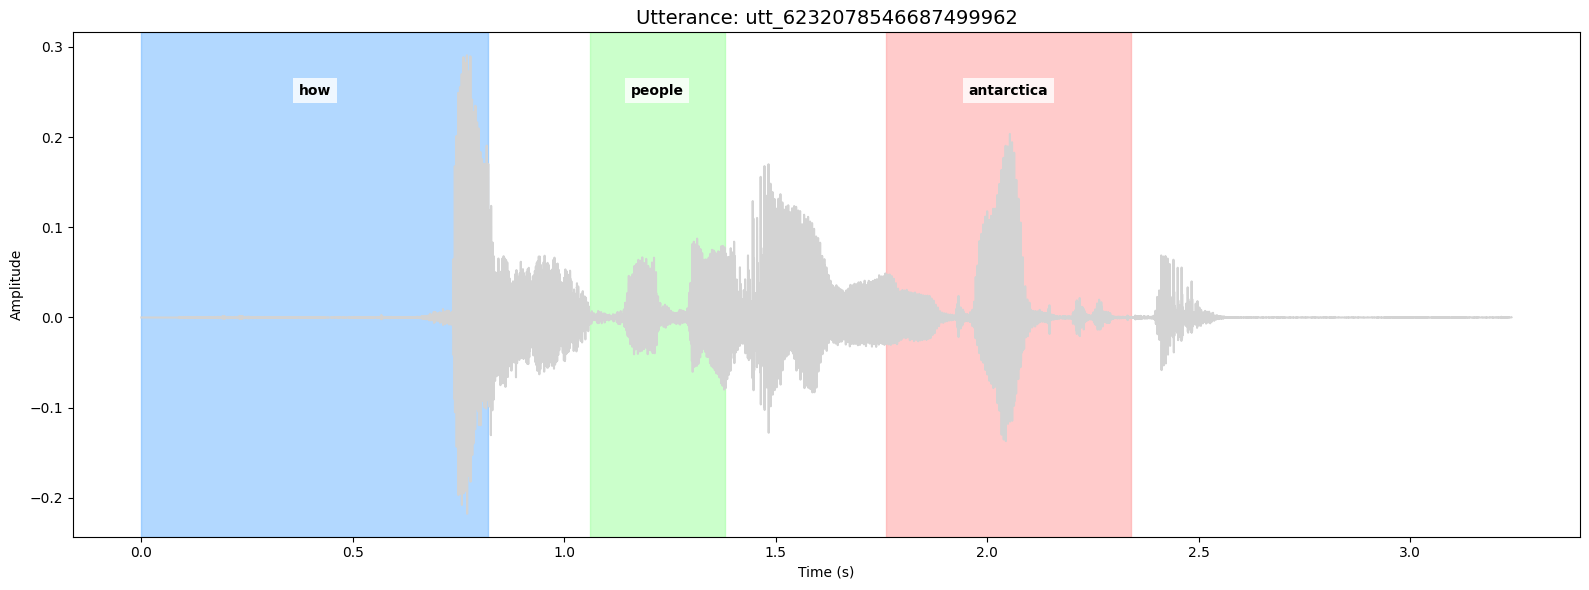


🔊 Play Audio:



⭐ SALIENCY RANK (Most Important First)
Rank 1: antarctica           (Occurs at: 1.76s - 2.34s)
Rank 2: how                  (Occurs at: 0.00s - 0.82s)
Rank 3: people               (Occurs at: 1.06s - 1.38s)


In [ ]:
# Visualize Waveform & Saliency Rank
# @markdown Visualizes the audio and prints terms ordered by **Saliency (Importance)**.


target_locale = "en_us" # @param ["en_us", "ar_eg", "bn_in", "de_de", "es_es", "fa_ir", "fi_fi", "id_id", "ja_jp", "ko_kr", "ru_ru", "sw_ke", "te_in", "th_th", "tr_tr", "zh_cn"]
target_utt_id = "utt_6232078546687499962" # @param {type:"string"}

def inspect_visuals(target_id, target_loc):
    if not target_id:
        print("⚠️ Please enter a valid utt_id.")
        return

    print(f"🔎 Scanning audio subset for ID: {target_id}...")

    ds_stream = load_dataset("google/svq", "audio", split="test", streaming=True)

    found_row = None
    search_limit = 100000

    for i, row in tqdm(enumerate(ds_stream), total=search_limit, desc="Scanning"):
        if i >= search_limit: break

        if row['locale'] != target_loc:
            continue

        if row['utt_id'] == target_id:
            found_row = row
            break

    if not found_row:
        print(f"\n❌ ID '{target_id}' not found.")
        return

    # --- Print Query ---
    print("\n" + "="*60)
    print(f"📝 QUERY: \"{found_row['text']}\"")
    print("="*60)

    # --- Manual Decode & Visualization ---
    raw_audio = found_row['waveform']

    if 'bytes' in raw_audio and raw_audio['bytes']:
        audio_arr, sr = sf.read(io.BytesIO(raw_audio['bytes']))
        duration = len(audio_arr) / sr
        time_axis = np.linspace(0, duration, len(audio_arr))

        # Plot
        plt.figure(figsize=(16, 6))
        plt.plot(time_axis, audio_arr, color='lightgray', label='Waveform')

        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

        terms = found_row['topk_salient_terms']
        timestamps = found_row['topk_salient_terms_timestamps']

        for i, (term, (start, end)) in enumerate(zip(terms, timestamps)):
            color = colors[i % len(colors)]
            plt.axvspan(start, end, color=color, alpha=0.5)

            mid = start + (end - start)/2
            plt.text(mid, max(audio_arr)*0.85, term,
                     ha='center', fontsize=10, fontweight='bold',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

        plt.title(f"Utterance: {target_id}", fontsize=14)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

        print("\n🔊 Play Audio:")
        ipd.display(ipd.Audio(audio_arr, rate=sr))

        # --- NEW: Print Saliency Rank ---
        print("\n" + "="*60)
        print("⭐ SALIENCY RANK (Most Important First)")
        print("="*60)

        # The list in 'topk_salient_terms' is already ordered by importance score
        for i, (term, (start, end)) in enumerate(zip(terms, timestamps), 1):
            print(f"Rank {i}: {term:<20} (Occurs at: {start:.2f}s - {end:.2f}s)")

    else:
        print("❌ Error: Audio bytes not accessible for this row.")

inspect_visuals(target_utt_id, target_locale)

# Retrieval Ground Truth Inspector

This section retrieves the knowledge ground truth for a specific utterance.

* Parameters: target_utt_id, target_locale, and retrieval_level.

* Retrieval Levels: 1) Document: Finds the Wikipedia Page Title. 2) Passage: Finds the specific Paragraph (Context). 3) Span: Finds the exact short Answer string.

* Formatting: Uses textwrap to ensure long passages are printed in a readable block format rather than a single long line.

In [ ]:
# Retrieval Ground Truth Inspector
# @markdown Select the **Retrieval Level** to see the Document, Context Passage, or Exact Answer Span.

target_utt_id = "utt_11477939086285057025" # @param {type:"string"}
target_locale = "en_us" # @param ["en_us", "ar_eg", "bn_in", "de_de", "es_es", "fa_ir", "fi_fi", "id_id", "ja_jp", "ko_kr", "ru_ru", "sw_ke", "te_in", "th_th", "tr_tr", "zh_cn"]
retrieval_level = "Span" # @param ["Document", "Passage", "Span"]

def find_retrieval_data(target_id, target_loc, level):
    if not target_id:
        print("⚠️ Please enter a valid utt_id.")
        return

    # 1. Select Subset based on Level
    if level == "Document":
        subset = "document_retrieval_in_lang"
    elif level == "Passage":
        subset = "span_retrieval_in_lang"
    else:
        subset = "span_reasoning_in_lang"

    print(f"🔎 Scanning subset '{subset}'...")

    # Load appropriate subset
    ds = load_dataset("google/svq", subset, split="test", streaming=True)

    found_data = None
    scan_limit = 200000
    match_count = 0

    # 2. Scan and Filter
    for i, row in tqdm(enumerate(ds), total=scan_limit, desc=f"Scanning"):
        if i >= scan_limit: break

        # Filter by locale
        row_loc = row.get('locale', '')
        if target_loc not in row_loc:
            continue

        match_count += 1

        # Check ID (Robust check)
        row_id = row.get('utt_id') or row.get('id')
        if row_id == target_id:
            found_data = row
            break

    # --- Display Results ---
    print(f"\n📊 Scanned {i} rows. Found {match_count} candidates in locale '{target_loc}'.")
    print("\n" + "="*60)
    print(f"📚 {level.upper()} GROUND TRUTH")
    print("="*60)

    if found_data:
        print(f"✅ EXACT MATCH FOUND!")

        q_text = found_data.get('question') or found_data.get('text')
        title = found_data.get('document_title') or found_data.get('page_title') or found_data.get('title')

        print(f"📝 Query:        {q_text}")
        print("-" * 60)
        print(f"📄 DOCUMENT:     {title}")

        # --- Formatted Passage ---
        if level in ["Passage", "Span"]:
            context = found_data.get('context') or found_data.get('passage_text') or ""

            # Wrap text to 80 chars
            wrapper = textwrap.TextWrapper(width=80, initial_indent="  ", subsequent_indent="  ")
            formatted_context = wrapper.fill(context)

            print("-" * 60)
            print("📖 PASSAGE:")
            print(formatted_context)

        # --- Answer Span ---
        if level == "Span":
            answers = found_data.get('answers', 'N/A')
            if isinstance(answers, dict):
                ans_str = answers.get('text', [''])[0]
            elif isinstance(answers, list):
                ans_str = answers[0]
            else:
                ans_str = str(answers)
            print("-" * 60)
            print(f"🎯 ANSWER SPAN:  \"{ans_str}\"")

        # --- Wikipedia Link ---
        if title:
            lang = target_loc.split('_')[0]
            url = f"https://{lang}.wikipedia.org/wiki/{title.replace(' ', '_')}"
            print("-" * 60)
            print(f"🔗 Wikipedia URL: {url}")

    else:
        print(f"❌ ID {target_id} not found in '{subset}'.")
        if level == "Span":
             print("Tip: This ID might exist in 'Document' or 'Passage' level but lack a specific Span.")

find_retrieval_data(target_utt_id, target_locale, retrieval_level)

🔎 Scanning subset 'span_reasoning_in_lang'...


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Scanning:  22%|██▏       | 43557/200000 [00:30<01:51, 1408.81it/s]


📊 Scanned 43557 rows. Found 3778 candidates in locale 'en_us'.

📚 SPAN GROUND TRUTH
✅ EXACT MATCH FOUND!
📝 Query:        What's the difference between a war and a conflict?
------------------------------------------------------------
📄 DOCUMENT:     War
------------------------------------------------------------
📖 PASSAGE:
  Library resources about   Main Page
------------------------------------------------------------
🎯 ANSWER SPAN:  "N/A"
------------------------------------------------------------
🔗 Wikipedia URL: https://en.wikipedia.org/wiki/War
